In [5]:
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
sys.path.append('../src')
from modules import (
                    paths,
                    dataset,
                    model,
                    utils
                    )
from torchvision.transforms import v2

In [6]:
toy = True
batch_size = 2

In [7]:
import importlib
importlib.reload(dataset)
if toy == True:
    print("laoding toy datasets")
    train_dataset = dataset.load("train", tiny=True, stop=2)
    val_dataset = dataset.load("valid", tiny=True, stop=2)

else:
    print("loading full dataet")
    train_dataset = dataset.load("train", stop=2)
    val_dataset = dataset.load("valid", stop=2)
print("train:\n"+str(train_dataset))
print("validation:\n"+str(val_dataset))


laoding toy datasets
Loading dataset from /home/lexyo/Dev/cv-proj2/notebooks/../data/train.pkl
Loading dataset from /home/lexyo/Dev/cv-proj2/notebooks/../data/valid.pkl
train:
Dataset({
    features: ['image', 'label'],
    num_rows: 400
})
validation:
Dataset({
    features: ['image', 'label'],
    num_rows: 400
})


In [8]:
transform_train = v2.Compose([
    v2.Lambda(lambda x: x.convert('RGB')),  # some images are in grayscale
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(),
    v2.RandAugment(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.RandomErasing(p=0.25),

])

transform_valid = v2.Compose([
    v2.Lambda(lambda x: x.convert('RGB')),  # some images are in grayscale
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [9]:
train_loader = DataLoader(
    dataset.TorchDatasetWrapper(train_dataset, transform_train),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,  
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)

val_loader = DataLoader(
    dataset.TorchDatasetWrapper(val_dataset, transform_valid),
    batch_size=3,
    shuffle=False,
    num_workers=2,  
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)

In [10]:
batch = next(iter(train_loader))

/home/lexyo/Dev/cv-proj2/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [88]:
importlib.reload(model)
config = {
    "patch_size": 8,
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48,
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 64,
    "num_classes": 10,
    "num_channels": 3,
    "qkv_bias": True,
}
# embedding = model.Embeddings(config)
# x = embedding(batch[0])
# single = model.AttentionHead(1000, 10, 0.1)
# single(x)
# multi = model.MultiHeadAttention(config)
# multi(x, output_attentions = True)
# encoder = model.Encoder(config)
# encoder(x)
# input = torch.ones(config["hidden_size"])
# bad_input = torch.ones(config["hidden_size"]) +100000
vit = model.ViT(config)

vit.prune_heads(['encoder.blocks.0.attention.heads.0.final_output', 'encoder.blocks.0.attention.heads.1.final_output', 'encoder.blocks.0.attention.heads.2.final_output', 'encoder.blocks.0.attention.heads.3.final_output',
                 'encoder.blocks.1.attention.heads.0.final_output', 'encoder.blocks.1.attention.heads.1.final_output', 'encoder.blocks.1.attention.heads.2.final_output', 'encoder.blocks.1.attention.heads.3.final_output'])

modules.model
[[], [], [], []]
encoder.blocks.1.attention.heads.0.final_output
encoder.blocks.1.attention.heads.1.final_output
encoder.blocks.0.attention.heads.2.final_output
encoder.blocks.1.attention.heads.3.final_output
encoder.blocks.0.attention.heads.1.final_output
encoder.blocks.0.attention.heads.0.final_output
encoder.blocks.1.attention.heads.2.final_output
encoder.blocks.0.attention.heads.3.final_output


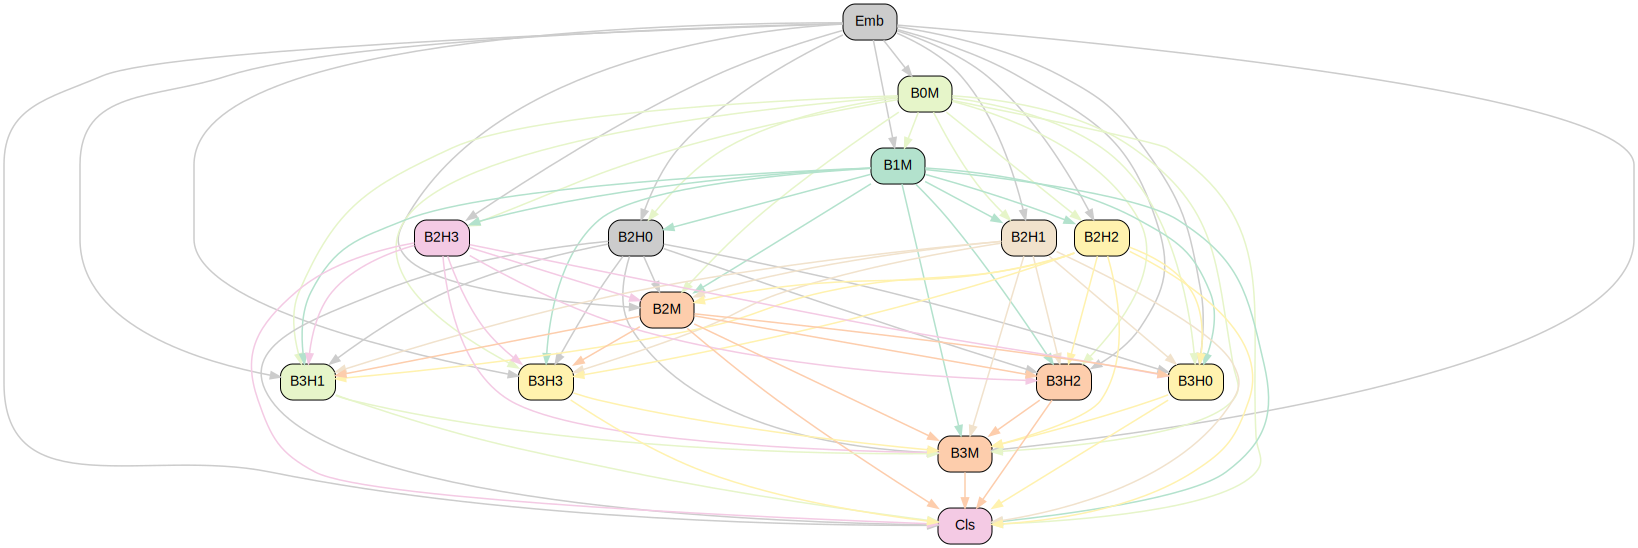

dict_keys(['embedding', 'classifier', 'encoder.blocks.0.mlp.final_output', 'encoder.blocks.1.mlp.final_output', 'encoder.blocks.2.mlp.final_output', 'encoder.blocks.2.attention.heads.0.final_output', 'encoder.blocks.2.attention.heads.1.final_output', 'encoder.blocks.2.attention.heads.2.final_output', 'encoder.blocks.2.attention.heads.3.final_output', 'encoder.blocks.3.mlp.final_output', 'encoder.blocks.3.attention.heads.0.final_output', 'encoder.blocks.3.attention.heads.1.final_output', 'encoder.blocks.3.attention.heads.2.final_output', 'encoder.blocks.3.attention.heads.3.final_output'])


In [91]:
importlib.reload(utils)

computation_graph = utils.ComputationalGraph(vit, config["num_hidden_layers"], config["num_attention_heads"])
computation_graph.visualize()
print(computation_graph.nodes.keys())

In [77]:
importlib.reload(utils)

with utils.SaveActivations(list(computation_graph.nodes.values())) as ctx:
    vit(batch[0])
    activations = ctx.get_activations()
activations

{'embedding.final_output': tensor([[[-6.2081e-03,  8.1159e-03, -7.0926e-04,  ..., -3.0283e-02,
            2.7131e-02,  2.7071e-02],
          [-1.3596e-01,  2.3805e-01,  4.3780e-01,  ..., -3.3515e-01,
           -2.7442e-02, -7.1327e-02],
          [-1.6907e-01,  7.2504e-02,  2.6849e-01,  ..., -2.4500e-01,
           -1.6769e-01,  1.1787e-01],
          ...,
          [ 9.1581e-01, -1.7935e-01,  1.8189e-01,  ...,  7.0521e-01,
            1.1804e+00,  1.0337e+00],
          [ 5.1428e-01,  3.3276e-02,  3.7766e-01,  ...,  3.6658e-01,
            6.7885e-01,  1.2712e-01],
          [ 4.3342e-01,  2.8913e-01,  5.1708e-01,  ..., -2.1929e-04,
            4.2138e-01,  2.9608e-01]],
 
         [[-6.2081e-03,  8.1159e-03, -7.0926e-04,  ..., -3.0283e-02,
            2.7131e-02,  2.7071e-02],
          [-1.7287e-01,  3.4777e-01,  4.9849e-01,  ..., -4.6270e-01,
           -2.0137e-01, -2.0243e-01],
          [-3.3042e-01,  3.7068e-01,  6.5260e-01,  ..., -4.8698e-01,
           -3.2814e-01, -1.6763

In [47]:
importlib.reload(utils)
with utils.ReplaceActivations(m.l2, activations["dense2"]):
    with utils.SaveActivations([(m.l1, "dense1"), (m.l2, "dense2")]) as ctx:
        print(m(torch.Tensor([1])))
        activations1 = ctx.get_activations()
    
print(activations1)

NameError: name 'm' is not defined